In [1]:
import scanpy as sc
import pandas as pd
import swan_vis as swan

In [45]:
adata = sc.read('habenula_transcripts.h5ad')

In [46]:
# filter for the cells in the habenula
celltypes = ['PHb-Neuron', 'MHb-Neuron', 'LHb-Neuron']
inds = adata.obs.loc[adata.obs.cell_type.isin(celltypes)].index
adata = adata[inds, :].copy()

In [47]:
# limit to Nr4a2 transcripts
inds = adata.var.loc[adata.var.gene_name == 'Nr4a2'].index
adata = adata[:, inds].copy()

In [52]:
# strip version from transcript id
# adata.var.head()
adata.var['tid'] = adata.var.tx_id.str.split('.', expand=True)[0]
adata.var.reset_index(drop=True, inplace=True)
adata.var.set_index('tid', inplace=True)

In [53]:
adata.var

,tx_id,gene_id,gene_name,gene_tx,chr,start,end
tid,,,,,,,
ENSMUST00000028166,ENSMUST00000028166.8,ENSMUST00000028166.8,Nr4a2,Nr4a2-201,chr2,57106830,57115038
ENSMUST00000112629,ENSMUST00000112629.7,ENSMUST00000112629.7,Nr4a2,Nr4a2-203,chr2,57106830,57124003
ENSMUST00000128776,ENSMUST00000128776.1,ENSMUST00000128776.1,Nr4a2,Nr4a2-204,chr2,57112990,57114373
ENSMUST00000140165,ENSMUST00000140165.1,ENSMUST00000140165.1,Nr4a2,Nr4a2-205,chr2,57112003,57115038
ENSMUST00000112627,ENSMUST00000112627.1,ENSMUST00000112627.1,Nr4a2,Nr4a2-202,chr2,57107499,57113072


In [54]:
# groupby celltype and group
obs_cols = ['cell_type', 'Group']
df = pd.DataFrame(data=adata.X.todense(), index=adata.obs.index.tolist(), \
	columns=adata.var.index.tolist())
df = df.merge(adata.obs[obs_cols], left_index=True, right_index=True)
df.reset_index(drop=True, inplace=True)
df = df.groupby(['cell_type', 'Group']).sum().reset_index()

# dump to formats that swan can handle
meta = df[['cell_type', 'Group']].copy(deep=True)
meta['dataset'] = meta.cell_type.astype('str') + '_' + meta.Group.astype('str')
meta.to_csv('swan_metadata.tsv', sep='\t', index=False)

df.drop(['cell_type', 'Group'], axis=1, inplace=True)

index = meta.dataset.tolist()
cols = df.columns.tolist()
data = df.values

df = pd.DataFrame(data=data, index=index, columns=cols)
df.reset_index(inplace=True)
df.rename({'index': 'dataset'}, axis=1, inplace=True)
df.set_index('dataset', inplace=True)
df = df.transpose()
df.index.name = 'transcript_id'
df.reset_index(inplace=True)
df.to_csv('swan_ab.tsv', sep='\t', index=False)

In [3]:
# swan stuff
sg = swan.SwanGraph(sc=True)
# sg.add_transcriptome('Mus_musculus.GRCm38.102.gtf', verbose=True)
sg.add_transcriptome('genes.gtf', verbose=False)

sg.save_graph('swan')
sg.add_abundance('swan_ab.tsv')
sg.add_metadata('swan_metadata.tsv')
sg.save_graph('swan')

In [2]:
sg = swan.read('swan.p')

# add some colors
c_dict = {'GFP' : '#98df8a',
          'Nurr2c': '#aec7e8'}
sg.set_metadata_colors('Group', c_dict)

c_dict = {'LHb-Neuron': '#ffbb78',
          'MHb-Neuron': '#fe7f0e',
          'PHb-Neuron': '#cd5c5b'}
sg.set_metadata_colors('cell_type', c_dict)

sg.save_graph('swan')
sg.t_df['novelty'] = 'Known'

Read in graph from swan.p
Saving graph as swan.p


In [4]:
sg.gen_report('Nr4a2',
              prefix='nr4a2_all',
              layer='pi',
              cmap='magma',
              display_numbers=True,
              transcript_col='tname',
              metadata_cols=['cell_type', 'Group'],
              browser=True,
              include_unexpressed=True)

                    LHb-Neuron_GFP  LHb-Neuron_Nurr2c  MHb-Neuron_GFP  \
tid                                                                     
ENSMUST00000140165       79.069771          92.771080       88.484848   
ENSMUST00000028166        3.488372           1.204819        3.030303   
ENSMUST00000112629        2.325581           1.204819        1.212121   
ENSMUST00000128776       15.116279           4.819277        6.666667   
ENSMUST00000112627        0.000000           0.000000        0.606061   

                    MHb-Neuron_Nurr2c  PHb-Neuron_GFP  PHb-Neuron_Nurr2c  
tid                                                                       
ENSMUST00000140165          82.969437             0.0          60.000004  
ENSMUST00000028166           2.183406           100.0          20.000000  
ENSMUST00000112629           2.183406             0.0          20.000000  
ENSMUST00000128776          11.353712             0.0           0.000000  
ENSMUST00000112627           1.310044 

In [ ]:
# plot report
sg.gen_report('Nr4a2',
              prefix='nr4a2',
              layer='pi',
              cmap='magma',
              display_numbers=True,
              transcript_col='tname',
              metadata_cols=['cell_type', 'Group'],
              browser=True)

sg.gen_report('Nr4a2',
              prefix='nr4a2_tpm',
              layer='tpm',
              cmap='viridis',
              transcript_col='tname',
              metadata_cols=['cell_type', 'Group'],
              browser=True)

In [59]:
sg.gen_report('Nr4a2',
            prefix='nr4a2_',
            layer='pi',
            cmap='magma',
            display_numbers=True,
            transcript_col='tname',
            metadata_cols=['cell_type', 'Group'])

sg.gen_report('Nr4a2',
            prefix='nr4a2_tpm',
            layer='tpm',
            cmap='viridis',
            transcript_col='tname',
            metadata_cols=['cell_type', 'Group'])


Plotting transcripts for ENSMUSG00000026826
Saving transcript path graph for ENSMUST00000140165 as nr4a2_ENSMUST00000140165_path.png
Saving transcript path graph for ENSMUST00000028166 as nr4a2_ENSMUST00000028166_path.png
Saving transcript path graph for ENSMUST00000112629 as nr4a2_ENSMUST00000112629_path.png
Saving transcript path graph for ENSMUST00000128776 as nr4a2_ENSMUST00000128776_path.png
Saving transcript path graph for ENSMUST00000112627 as nr4a2_ENSMUST00000112627_path.png
Generating report for ENSMUSG00000026826

Plotting transcripts for ENSMUSG00000026826
Saving transcript path graph for ENSMUST00000140165 as nr4a2_tpm_ENSMUST00000140165_path.png
Saving transcript path graph for ENSMUST00000028166 as nr4a2_tpm_ENSMUST00000028166_path.png
Saving transcript path graph for ENSMUST00000112629 as nr4a2_tpm_ENSMUST00000112629_path.png
Saving transcript path graph for ENSMUST00000128776 as nr4a2_tpm_ENSMUST00000128776_path.png
Saving transcript path graph for ENSMUST00000112627 

In [63]:
sg.t_df.loc[sg.t_df.gname=='Nr4a2']

,tname,gid,gname,path,tid,loc_path,novelty
tid,,,,,,,
ENSMUST00000028166,Nr4a2-201,ENSMUSG00000026826,Nr4a2,"[59628, 59629, 59630, 59631, 59632, 59633, 596...",ENSMUST00000028166,"[341759, 341758, 341754, 341752, 341751, 34174...",Known
ENSMUST00000112627,Nr4a2-202,ENSMUSG00000026826,Nr4a2,"[59630, 59645, 59646, 59633, 59634, 59635, 596...",ENSMUST00000112627,"[341754, 341752, 341750, 341748, 341747, 34174...",Known
ENSMUST00000112629,Nr4a2-203,ENSMUSG00000026826,Nr4a2,"[59643, 59644, 59630, 59631, 59632, 59633, 596...",ENSMUST00000112629,"[341761, 341760, 341754, 341752, 341751, 34174...",Known
ENSMUST00000128776,Nr4a2-204,ENSMUSG00000026826,Nr4a2,"[59653, 59654, 59655]",ENSMUST00000128776,"[341757, 341756, 341754, 341753]",Known
ENSMUST00000140165,Nr4a2-205,ENSMUSG00000026826,Nr4a2,"[59628, 59650, 59651, 59631, 59652]",ENSMUST00000140165,"[341759, 341758, 341755, 341752, 341751, 341749]",Known
ENSMUST00000183542,Nr4a2-206,ENSMUSG00000026826,Nr4a2,"[59643, 59644, 59630, 59645, 59646, 59633, 596...",ENSMUST00000183542,"[341761, 341760, 341754, 341752, 341750, 34174...",Known


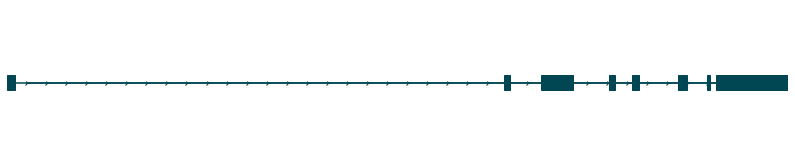

In [64]:
sg.plot_transcript_path('ENSMUST00000183542', browser=True)

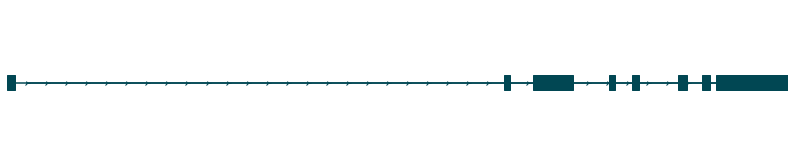

In [8]:
sg.plot_transcript_path('ENSMUST00000112629', browser=True)

In [3]:
sg.plot_graph('Nr4a2', prefix='nr4a2_summary')

Saving summary graph for ENSMUSG00000026826 as nr4a2_summary_ENSMUSG00000026826_summary.png


In [10]:
# nurr2c isoform
sg.plot_transcript_path('ENSMUST00000183542', prefix='nurr2c')

Saving transcript path graph for ENSMUST00000183542 as nurr2c_ENSMUST00000183542_path.png


In [11]:
sg.plot_transcript_path('ENSMUST00000112629', prefix='not_nurr2c')

Saving transcript path graph for ENSMUST00000112629 as not_nurr2c_ENSMUST00000112629_path.png


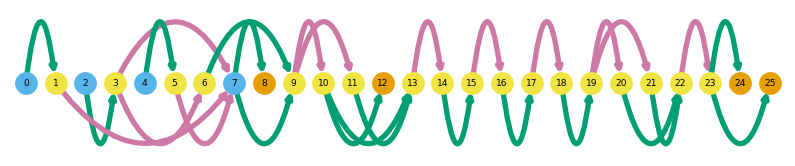

In [7]:
sg.plot_graph('Nr4a2')
plt.savefig('nr4a2_summary.pdf')

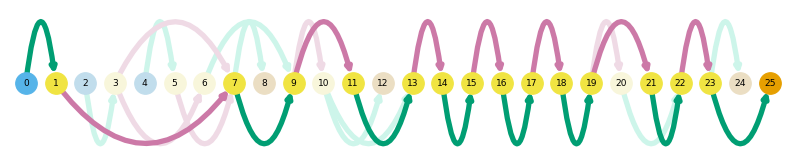

In [8]:
# nurr2c isoform
sg.plot_transcript_path('ENSMUST00000183542')
plt.savefig('nr4a2_nurr2c.pdf')

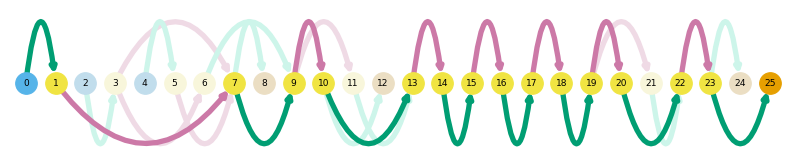

In [9]:
# not nurr2c
sg.plot_transcript_path('ENSMUST00000112629')
plt.savefig('nr4a2_not_nurr2c.pdf')